#### Single model data analysis

In [1]:
from data import data

import pickle

import matplotlib.lines as mlines

import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
area_names = data.mrdh65_to_name

folder = ""
image_folder = "default/"
image_name = "default"
# load_names = ["base1_rush", "default_fixed", "default_fixed_09"]
# runs = ["default", "default_fixed", "default_fixed_09"]

# speed_reduction 0, 0.5 and 1
load_names = ["default_fixed"]
runs = ["default"]


journeys_dict = {}
uxsim_dict = {}
parked_dict = {}

for run, load_name in zip(runs, load_names):
    with open(f"../results/{folder}uxsim_df_{load_name}.pkl", "rb") as f:
        uxsim_dict[run] = pickle.load(f)
    with open(f"../results/{folder}parked_dict_{load_name}.pkl", "rb") as f:
        parked_dict[run] = pickle.load(f)
    journeys_dict[run] = pd.read_feather(f"../results/{folder}journeys_df_{load_name}.feather")

In [3]:
city_areas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 28, 29, 31, 34, 41, 43, 44, 45]
city_area_names = [area_names[area] for area in city_areas]

trips_by_hour_chances = pd.read_pickle("../data/trips_by_hour_chances.pickle")

start_time, end_time = int(journeys_dict[runs[0]]['start_time'].min()), int(journeys_dict[runs[0]]['start_time'].max())
print(f"Start time: {start_time}, End time: {end_time}")

Start time: 5, End time: 23


In [4]:
# Throw away the first 15 minutes. Road network is not fully loaded yet, so travel times are often 0.
for run, journeys_df in journeys_dict.items():
    journeys_dict[run] = journeys_df[journeys_df['start_time'] >= start_time + 0.25]

### Journeys data

default Mode choice distribution: {'bike': '58.39%', 'car': '29.78%', 'transit': '11.83%'}
default Distance weighted mode choice distribution: {'bike': '45.90%', 'car': '33.43%', 'transit': '20.66%'}


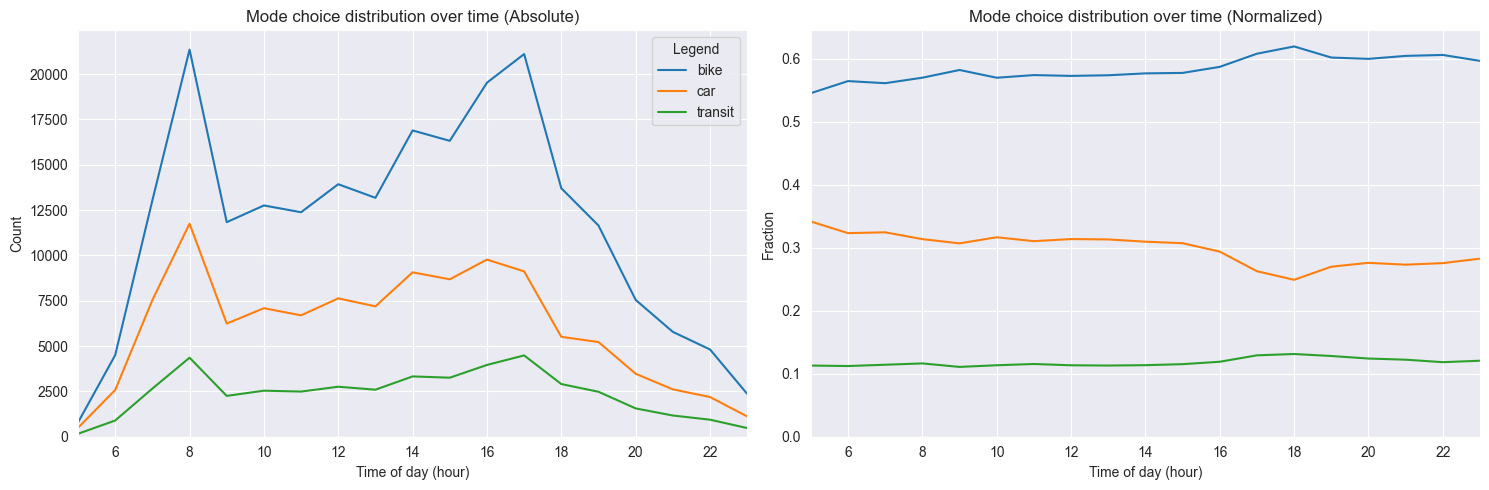

In [5]:
# Print the mode choice distribution
mode_counts = {}
mode_counts_weighted = {}
journey_counts = {}
journey_counts_norm = {}

for run, journeys_df in journeys_dict.items():
    mode_counts[run] = journeys_df['mode'].value_counts(normalize=True).to_dict()
    print(f"{run} Mode choice distribution: {({mode: f"{count:.2%}" for mode, count in mode_counts[run].items()})}")
    
    # Distance weighted mode choice distribution
    mode_counts_weighted[run] = journeys_df.groupby('mode', observed=True)['distance'].sum() / journeys_df['distance'].sum()
    print(f"{run} Distance weighted mode choice distribution: {({mode: f"{count:.2%}" for mode, count in mode_counts_weighted[run].items()})}")
    
    # start_time hour (float to int)
    journeys_df['start_time_h'] = journeys_df['start_time'].astype(int)
    
    # Group by start_time
    journeys_grouped = journeys_df.groupby(['start_time_h'])
    journey_counts[run] = journeys_grouped['mode'].value_counts(normalize=False).unstack().fillna(0)
    # Get the percentage for each mode of each hour in a dataframe
    journey_counts_norm[run] = journeys_grouped['mode'].value_counts(normalize=True).unstack().fillna(0)
    
# Convert journey_counts and journey_counts_norm into multi-indexed DataFrames
journey_counts_df = pd.concat(journey_counts, axis=0, keys=journey_counts.keys(), names=["Run", "Hour"]).stack().reset_index()
journey_counts_norm_df = pd.concat(journey_counts_norm, axis=0, keys=journey_counts_norm.keys(), names=["Run", "Hour"]).stack().reset_index()

# Plot with seaborn
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

run_line_styles = ["solid", "dashed", "dashdot", "dotted"]
run_line_styles = {run: style for run, style in zip(runs, run_line_styles)}

for i, df in enumerate([journey_counts_df, journey_counts_norm_df]):
    for run in runs:
        dfr = df[df['Run'] == run]
        style = run_line_styles[run]
        sns.lineplot(data=dfr, x='Hour', y=0, hue='mode', linestyle=style, ax=axs[i])
    axs[i].set_title(f"Mode choice distribution over time ({'Absolute' if i == 0 else 'Normalized'})")
    if i == 1:
        axs[i].set_ylabel('Fraction')
    else:
        axs[i].set_ylabel('Count')
    axs[i].set_xlabel('Time of day (hour)')
    axs[i].set_xlim(start_time, end_time)
    axs[i].set_ylim(bottom=0)
    if i == 1:
        axs[i].get_legend().remove()

# Custom legends
mode_colors = sns.color_palette()
mode_legend_lines = [mlines.Line2D([], [], color=color, linestyle='-', label=mode) for color, mode in zip(mode_colors, df['mode'].unique())]
custom_legend = mode_legend_lines
axs[0].legend(handles=custom_legend, title='Legend', loc='upper right')

plt.tight_layout()
plt.savefig(f'../img/{image_folder}/mode_distribution_{image_name}.svg', bbox_inches='tight')

In [6]:
for run, journeys_df in journeys_dict.items():
    # Local analysis. Select the 65x65 areas ['Noord', 'Kralingen', 'Rotterdam Centrum', 'Feyenoord', 'Delfshaven'] from journeys_df.mrdh65. Use the data.mrdh65_to_name dictionary to map the area numbers to names.
    inner_rotterdam = ['Noord', 'Kralingen', 'Rotterdam Centrum', 'Feyenoord', 'Delfshaven']
    # origin is in pc4, use data.pc4_to_mrdh65_city to map to mrdh65
    journeys_df["origin_mrdh65_name"] = journeys_df["origin"].map(data.pc4_to_mrdh65_city).map(data.mrdh65_to_name)
    journeys_df["destination_mrdh65_name"] = journeys_df["destination"].map(data.pc4_to_mrdh65_city).map(data.mrdh65_to_name)
    
    # Filter the area index over city_areas
    journeys_df_rc = journeys_df[(journeys_df['origin_mrdh65_name'].isin(inner_rotterdam)) & (journeys_df['destination_mrdh65_name'].isin(inner_rotterdam))]
    print(f"Selected {len(journeys_df_rc)} journeys from the inner Rotterdam areas ({len(journeys_df_rc) / len(journeys_df):.2%}) of the total journeys.")
    
    # Print the mode choice distribution
    mode_counts = journeys_df_rc['mode'].value_counts(normalize=True).to_dict()
    print(f"Mode choice distribution: {({mode: f"{count:.2%}" for mode, count in mode_counts.items()})}")
    
    # Distance weighted mode choice distribution
    mode_counts_weighted = journeys_df_rc.groupby('mode', observed=True)['distance'].sum() / journeys_df_rc['distance'].sum()
    print(f"Distance weighted mode choice distribution: {({mode: f"{count:.2%}" for mode, count in mode_counts_weighted.items()})}\n")

Selected 87063 journeys from the inner Rotterdam areas (22.75%) of the total journeys.
Mode choice distribution: {'bike': '69.68%', 'car': '23.61%', 'transit': '6.71%'}
Distance weighted mode choice distribution: {'bike': '66.49%', 'car': '24.18%', 'transit': '9.32%'}



In [7]:
label_journey_dict = {
    'travel_time_min': 'Travel time',
    'distance': 'Distance',
    'cost': 'Cost',
    'perceived_cost': 'Perceived cost'
}

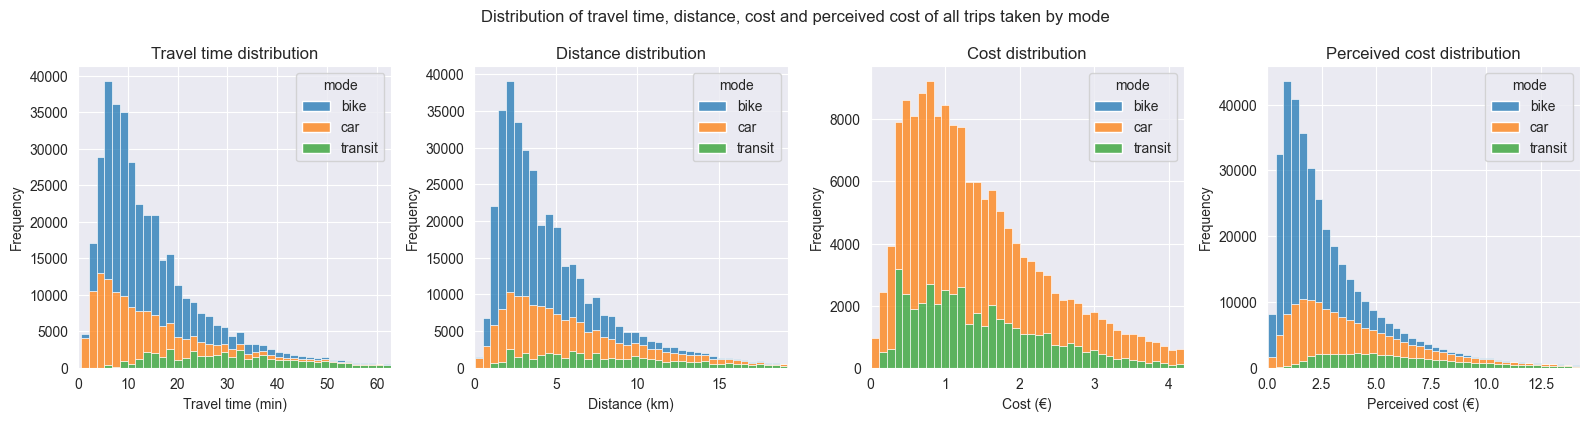

In [8]:
height = len(runs) * 4 + 0.25
fig, axs = plt.subplots(len(runs), 4, figsize=(16, height))
if len(runs) == 1:
    axs = axs[np.newaxis, :]

color_dict = {'bike': 'tab:blue', 'car': 'tab:orange', 'transit': 'tab:green', 'av': 'tab:red'}

for j, (run, journeys_df) in enumerate(journeys_dict.items()):
    journeys_df['travel_time_min'] = journeys_df['travel_time'] / 60
    # Sort by mode, in this order: bike, car, transit, av
    journeys_df = journeys_df.sort_values('mode', key=lambda x: x.map({'bike': 0, 'car': 1, 'transit': 2, 'av': 3}))
    
    n_bins = 40
    hist_columns = ['travel_time_min', 'distance', 'cost', 'perceived_cost']
    x_labels = ['Travel time (min)', 'Distance (km)', 'Cost (€)', 'Perceived cost (€)']
    upper_xlim = [journeys_df[col].quantile(0.99) for col in hist_columns]
    
    # Histogram of each column
    
    for i, col in enumerate(hist_columns):
        plot_df = journeys_df[(journeys_df[col] < upper_xlim[i]) & (journeys_df[col] > 0)][[col, 'mode']].copy()
        sns.histplot(plot_df, x=col, hue='mode', multiple='stack', ax=axs[j, i], bins=n_bins, palette=color_dict)
        if j == 0:
            axs[j, i].set_title(f'{label_journey_dict[col]} distribution')
        axs[j, i].set_xlabel(x_labels[i])
        axs[j, i].set_ylabel('Frequency')
        axs[j, i].set_xlim(0, upper_xlim[i])

# Add title
plt.suptitle('Distribution of travel time, distance, cost and perceived cost of all trips taken by mode')
plt.tight_layout()
plt.savefig(f'../img/{image_folder}/journeys_data_{image_name}.svg', bbox_inches='tight')
plt.show()

### Input data visualization (for comparison)

In [9]:
# For a weekday, take the average of days 0-3 (Monday-Thursday)
trips_by_hour_chance = trips_by_hour_chances.iloc[:, 0:4].mean(axis=1).drop("Total")
# Drop the hours that are not in the range of the model and save as a dictionary
trips_by_hour_chance = trips_by_hour_chance.loc[start_time:(end_time)]
# Set column name
trips_by_hour_chance.name = 'Chance'
# To df
trips_by_hour_chance = trips_by_hour_chance.reset_index()
# Set hour as int
trips_by_hour_chance['Hour'] = trips_by_hour_chance['Hour'].astype(int)
trips_by_hour_chance.head(3)

,Hour,Chance
0,5,0.017868
1,6,0.076817
2,7,0.231816


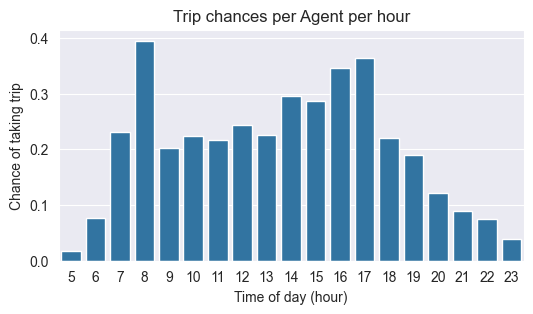

In [10]:
# Plot trips_by_hour_chances series
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(data=trips_by_hour_chance, x='Hour', y='Chance', ax=ax)
ax.set_title('Trip chances per Agent per hour')
ax.set_ylabel('Chance of taking trip')
ax.set_xlabel('Time of day (hour)')
# Save
plt.savefig(f'../img/input_data.png', dpi=300, bbox_inches='tight')

### UXsim data analysis

In [11]:
for run, uxsim_df in uxsim_dict.items():
    # time_bin (first level multi index) from seconds to hours
    uxsim_df.index = pd.MultiIndex.from_tuples([(time/3600+start_time, area) for time, area in uxsim_df.index], names=['time_bin', 'area'])
    
    # Filter the area index over city_areas
    uxsim_df = uxsim_df.loc[(slice(None), city_areas), :]

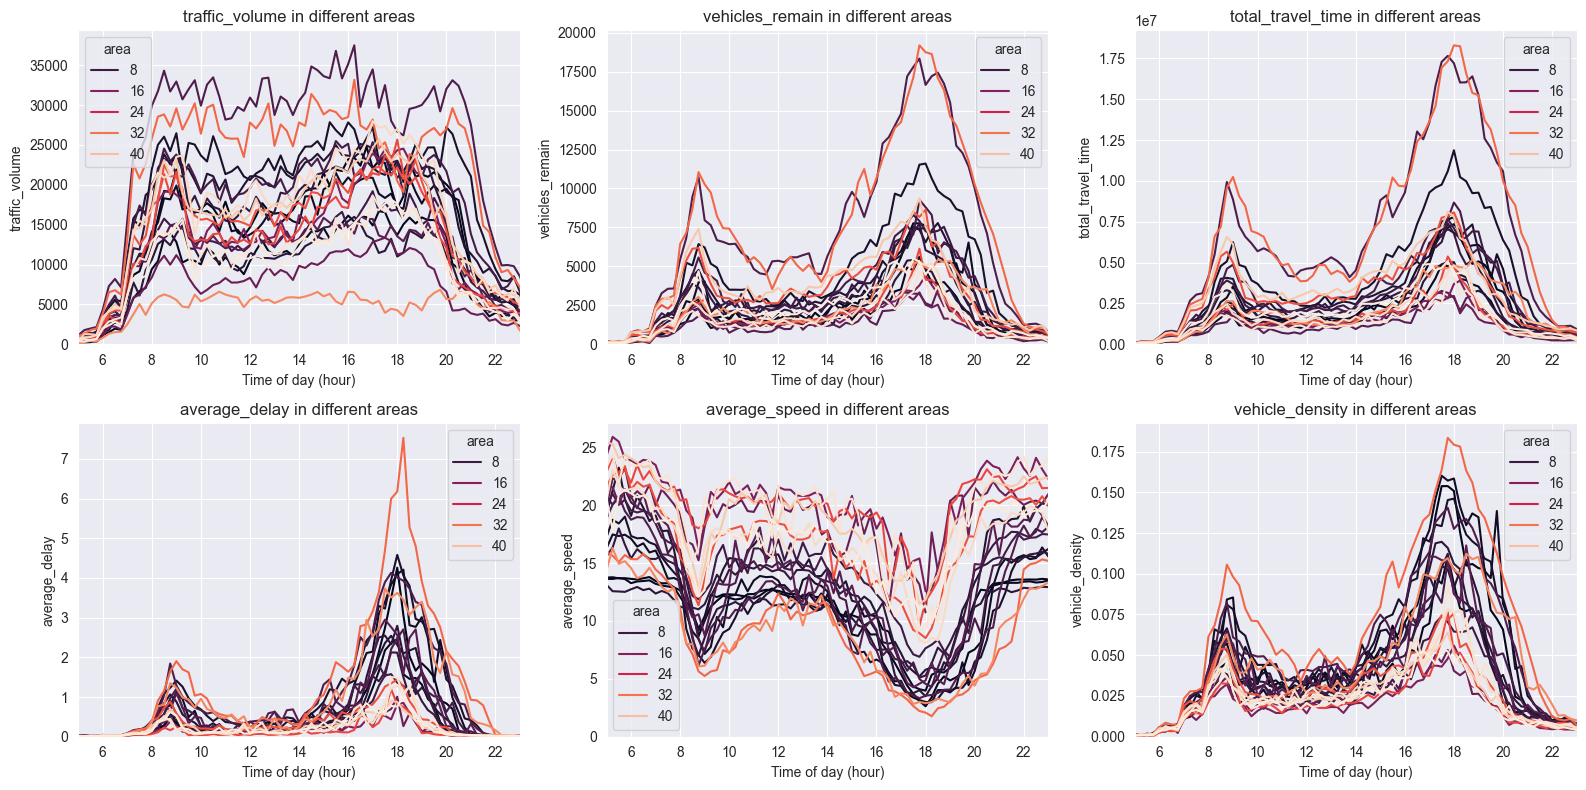

In [12]:
# Plot
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flatten()

plot_run = "default"
for i, variable in enumerate(uxsim_dict[plot_run].columns):
    sns.lineplot(data=uxsim_df, x='time_bin', y=variable,  ax=axs[i], errorbar=("pi", 50), hue='area', palette='rocket')
    axs[i].set_title(f"{variable} in different areas")
    axs[i].set_ylabel(variable)
    axs[i].set_xlabel('Time of day (hour)')
    axs[i].set_xlim(start_time, end_time)
    axs[i].set_ylim(bottom=0)

# Add a title

# Tight layout
plt.tight_layout()
plt.savefig(f'../img/{image_folder}/uxsim_data_{image_name}_{plot_run}.png', dpi=300, bbox_inches='tight')

In [13]:
# # Merge into one df
# long_uxsim_df = pd.concat(uxsim_dict, axis=0, keys=uxsim_dict.keys(), names=["Run"]).stack().reset_index()
# long_uxsim_df.columns = ['Run', 'time_bin', 'area', 'variable', 'value']
# 
# # Plot
# fig, axs = plt.subplots(3, 2, figsize=(14, 14))
# axs = axs.flatten()
# errorbar = ("pi", 50)
# 
# for i, variable in enumerate(uxsim_dict[runs[0]].columns):
#     sns.lineplot(data=long_uxsim_df[long_uxsim_df['variable'] == variable], x='time_bin', y='value',  ax=axs[i], errorbar=errorbar, hue='run')
#     axs[i].set_title(f"{variable} in different areas")
#     axs[i].set_ylabel(variable)
#     axs[i].set_xlabel('Time of day (hour)')
#     axs[i].set_xlim(start_time, end_time)
#     axs[i].set_ylim(bottom=0)
# # Add a legend
# labels = [[f'Run {run}', f"{errorbar[1]}% {errorbar[0]}"] for run in runs]
# flat_labels = [item for sublist in labels for item in sublist]
# fig.legend(title='Run', loc=(0.9, 0.5), labels=flat_labels)
# 
# plt.savefig(f'../img/{image_folder}/uxsim_data_{image_name}.png', dpi=300, bbox_inches='tight')

In [14]:
single_run = uxsim_dict["default"]
# Only keep the areas in city_areas
single_run = single_run[single_run.index.get_level_values('area').isin(city_areas)]
# Sort by area number
single_run = single_run.sort_index(level='area')
# Convert total_travel_time to hours
single_run['total_travel_time'] = single_run['total_travel_time'] / 3600
single_run

,,traffic_volume,vehicles_remain,total_travel_time,average_delay,average_speed,vehicle_density
time_bin,area,,,,,,
5.00,1,320.0,70.0,9.319598,0.010517,13.744333,0.001387
5.25,1,500.0,40.0,10.959956,0.006184,13.773746,0.000793
5.50,1,490.0,60.0,10.727964,0.010842,13.679061,0.001189
5.75,1,570.0,70.0,11.959373,0.014135,13.695309,0.001387
6.00,1,1430.0,170.0,35.964607,0.017789,13.635215,0.003369
...,...,...,...,...,...,...,...
22.75,45,3850.0,500.0,148.362037,0.030934,19.500469,0.004936
23.00,45,2750.0,420.0,106.614815,0.014176,20.494411,0.004147
23.25,45,1740.0,340.0,83.429012,0.016301,19.567693,0.003357


In [15]:
# ['traffic_volume', 'vehicles_remain', 'total_travel_time', 'average_delay', 'average_speed', 'vehicle_density']

# Readable labels dict
labels_dict = {
    "traffic_volume": "Total traffic volume (cars)",
    "vehicles_remain": "Simultaneous vehicles on the roads (cars)",
    "total_travel_time": "Total travel time of vehicles passing (hours)",
    "average_delay": "Average delay of vehicles in the area (factor)",
    "average_speed": "Average speed of vehicles in the area (km/h)",
    "vehicle_density": "Vehicle density on the roads (cars/m)"
}

colormap_dict = {
    "traffic_volume": "coolwarm",
    "vehicles_remain": "coolwarm",
    "total_travel_time": "coolwarm",
    "average_delay": "RdYlGn_r",
    "average_speed": "RdYlGn",
    "vehicle_density": "RdYlGn_r",
}

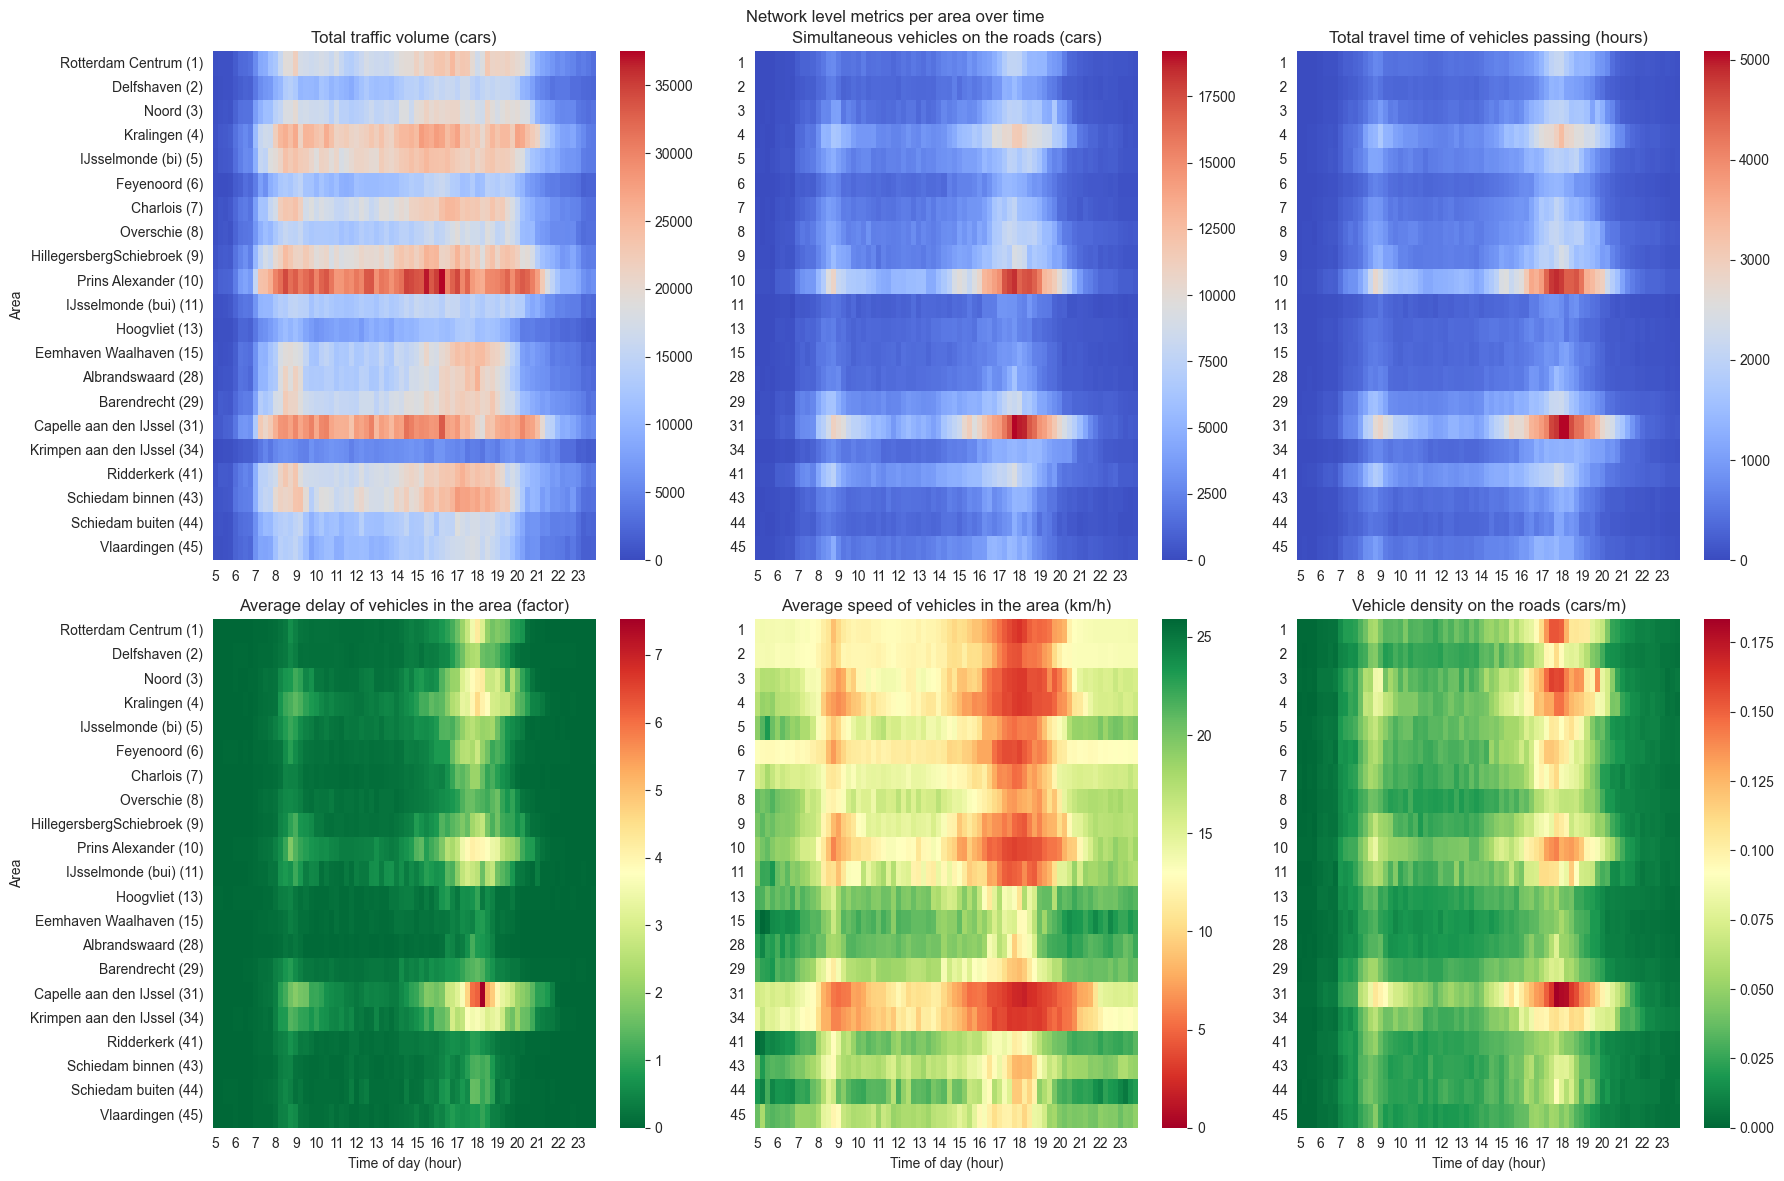

In [16]:
# Create heatmaps
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

for i, variable in enumerate(single_run.columns):
    unstacked = single_run[variable].unstack().T
    # Replace the area numbers with the area names in the first and 4th subplot
    if i in [0, 3]:
        unstacked.index = [f"{area_names[area]} ({area})" for area in unstacked.index]
    else:
        # Otherwise, rotate the x-tick labels
        unstacked.index = [f"    {area}" for area in unstacked.index]
    
    sns.heatmap(unstacked, cmap=colormap_dict[variable], ax=axs[i], vmin=0)
    # Add the title
    axs[i].set_title(labels_dict[variable])
    # Display only the whole hours as x-tick labels
    axs[i].set_xticklabels([f"{hour}" for hour in range(start_time, end_time+1)], rotation=0)
    # Set the axis labels
    if i in [0, 3]:
        axs[i].set_ylabel('Area')
    if i in [3, 4, 5]:
        axs[i].set_xlabel('Time of day (hour)')
    else:
        axs[i].set_xlabel('')
# Add title
plt.suptitle('Network level metrics per area over time')
# Tight layout
plt.tight_layout()
# Save figure
plt.savefig(f'../img/{image_folder}/uxsim_heatmaps_{image_name}.png', dpi=300, bbox_inches='tight')

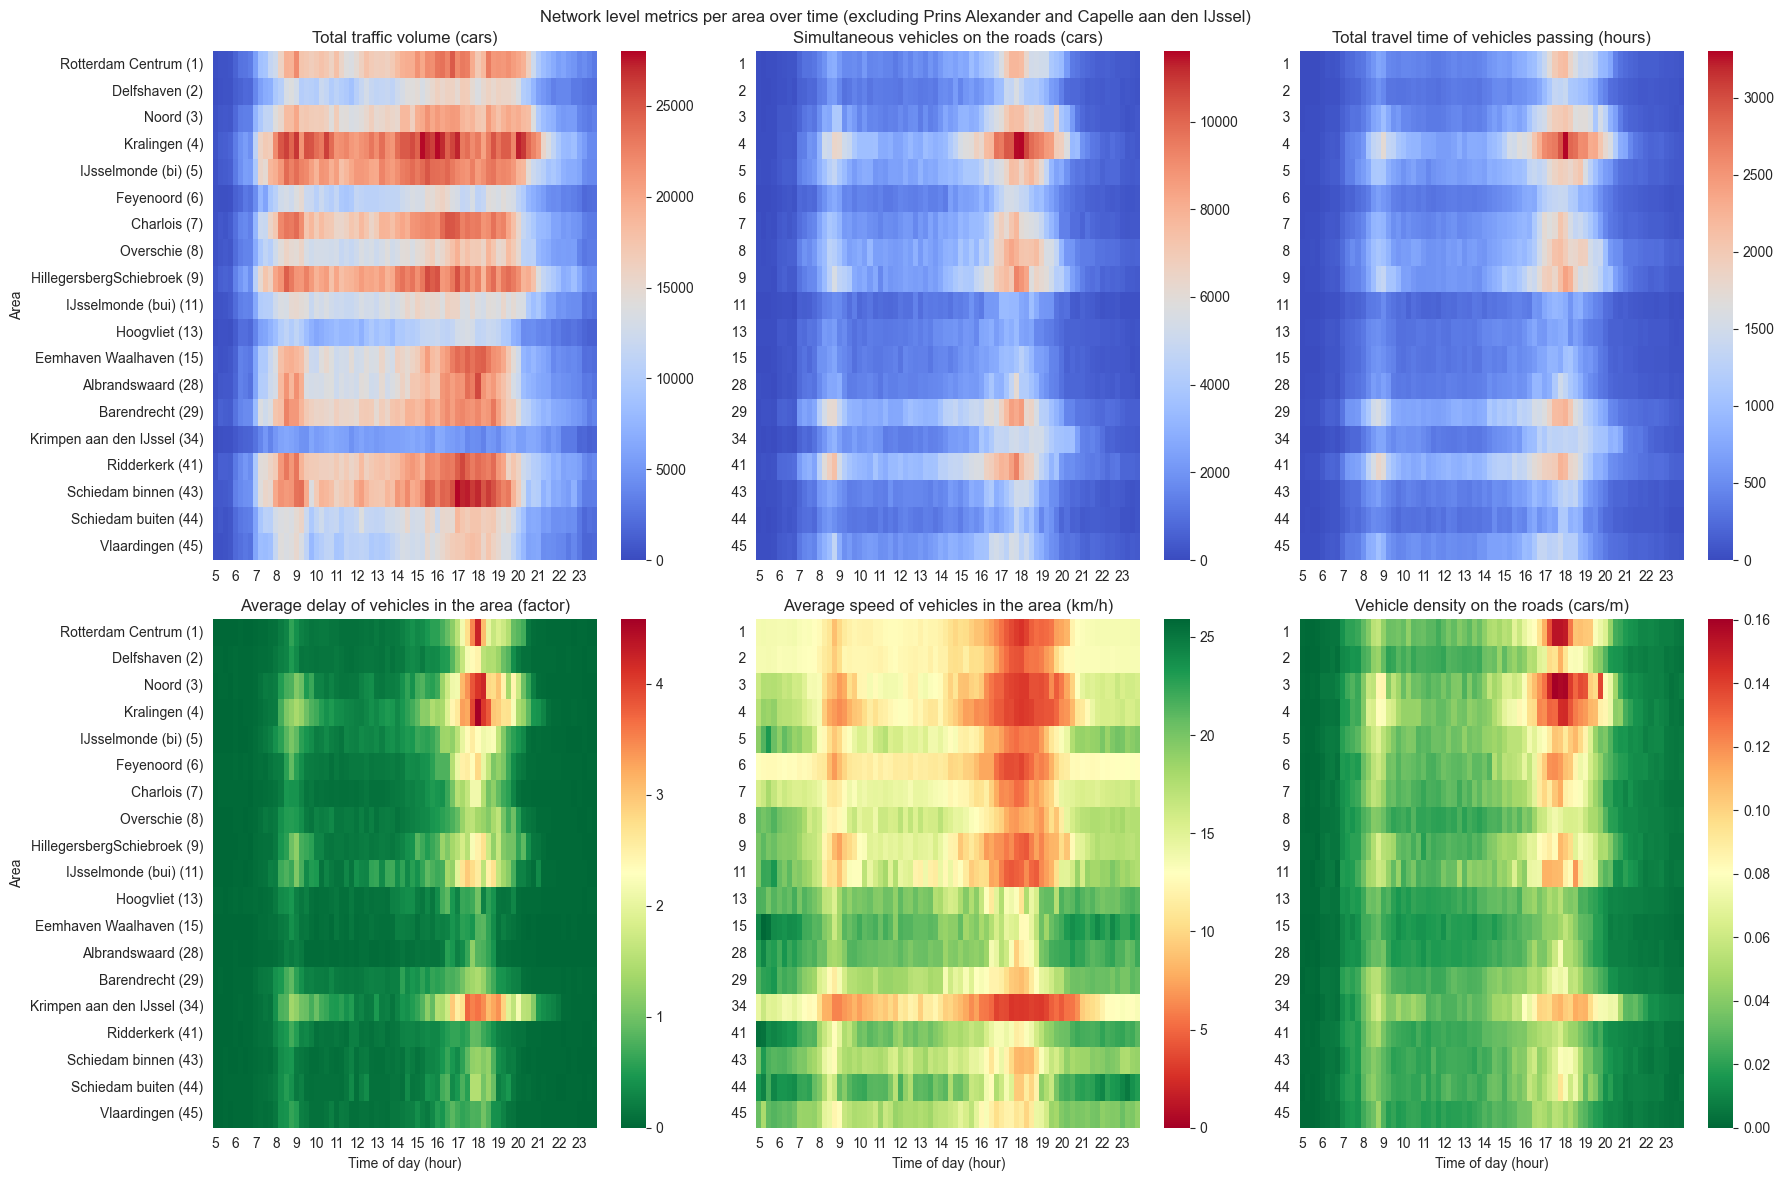

In [17]:
# Remove regions 10 and 31 and plot again
single_run_sel = single_run.drop([10, 31], level='area')
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

for i, variable in enumerate(single_run_sel.columns):
    unstacked = single_run_sel[variable].unstack().T
    # Replace the area numbers with the area names in the first and 4th subplot
    if i in [0, 3]:
        unstacked.index = [f"{area_names[area]} ({area})" for area in unstacked.index]
    else:
        # Otherwise, rotate the x-tick labels
        unstacked.index = [f"    {area}" for area in unstacked.index]
    
    sns.heatmap(unstacked, cmap=colormap_dict[variable], ax=axs[i], vmin=0)
    # Add the title
    axs[i].set_title(labels_dict[variable])
    # Display only the whole hours as x-tick labels
    axs[i].set_xticklabels([f"{hour}" for hour in range(start_time, end_time+1)], rotation=0)
    # Set the axis labels
    if i in [0, 3]:
        axs[i].set_ylabel('Area')
    if i in [3, 4, 5]:
        axs[i].set_xlabel('Time of day (hour)')
    else:
        axs[i].set_xlabel('')
# Add title
plt.suptitle(f'Network level metrics per area over time (excluding {area_names[10]} and {area_names[31]})')
# Tight layout
plt.tight_layout()
# Save figure
plt.savefig(f'../img/{image_folder}/uxsim_heatmaps_{image_name}_clean.png', dpi=300, bbox_inches='tight')

### Parking data visualization

In [18]:
# Convert parked_dict to DataFrame
for run, parked_df in parked_dict.items():
    parked_df = pd.DataFrame(parked_df)
    parked_dict[run] = parked_df

# Concatenate the DataFrames
parked_df = pd.concat(parked_dict, axis=0, keys=parked_dict.keys(), names=["run"])

# Set column as index
parked_df = parked_df.stack().reset_index()
parked_df.columns = ['run', 'area', 'time', 'value']
# Set index Run, Area, Time
parked_df = parked_df.set_index(['run', 'area', 'time'])
# Swap Area and time index levels
parked_df = parked_df.swaplevel('area', 'time')
parked_df.head(3)

value
run     time     area       
default 5.000000 1       905
        5.083333 1       905
        5.166667 1       904

In [19]:
gdf_mrdh_65 = pd.read_pickle("../data/areas_mrdh_weighted_centroids.pkl")

In [20]:
with open("../data/polygons.pkl", "rb") as f:
    city_polygon, area_polygon, autoluw_polygon = pickle.load(f)

city_polygon_series = gpd.GeoSeries(city_polygon, crs="epsg:4326")
city_polygon_series = city_polygon_series.to_crs(epsg=28992)
gdf_mrdh_65["in_city"] = gdf_mrdh_65.centroid.within(city_polygon_series.geometry[0])
gdf_mrdh_65 = gdf_mrdh_65[gdf_mrdh_65["in_city"]]

In [21]:
# Normalize the parked cars data by the first time step of that run
parked_df["parked_norm"] = parked_df["value"] / parked_df.groupby(['run', 'area'])['value'].transform('first')

In [22]:
gdf_mrdh_65

,geometry,65x65 Naam,GEBIEDEN,WONINGEN_A,INWONERS_A,ARBEIDSPL_,LLP12EO_AR,LLP0011_AR,PARKEER_TA,AUTOSPERHH,...,3: inwon0034,4: bbv,5: llp12eo,6: detail,7: industrie,8: rest,9: arbeidspl_totaal,10: gebiedstype,weighted_centroid,in_city
65x65 Nummer,,,,,,,,,,,,,,,,,,,,,
1,"MULTIPOLYGON (((91572.39 435285.08, 91571.6 43...",Rotterdam Centrum,studiegebied RVMK,21529,36209,88158,37649,2213,4.14,0.495,...,18948,16284,37649,9151,7019,71988,88158,1,POINT (92503.521 436954.513),True
2,"POLYGON ((89429 435269.999, 89384 435277.999, ...",Delfshaven,studiegebied RVMK,39740,77508,17468,9165,6332,1.76,0.460,...,41160,30429,9165,3430,1068,12970,17468,1,POINT (90184.321 436555.593),True
3,"POLYGON ((89677.053 437491.512, 89672.17 43749...",Noord,studiegebied RVMK,29516,52490,12453,10649,2807,1.76,0.425,...,27808,23956,10649,3235,499,8719,12453,1,POINT (92000.067 438691.886),True
4,"POLYGON ((93801.859 437558.61, 93800.797 43756...",Kralingen,studiegebied RVMK,30714,53939,25025,36520,4257,1.76,0.480,...,28785,19379,36520,2758,4634,17633,25025,1,POINT (94475.837 437996.54),True
5,"POLYGON ((94944.584 431561.346, 94944.374 4315...",IJsselmonde (bi),studiegebied RVMK,22324,45467,16658,4404,3906,0.00,0.650,...,19990,16927,4404,2587,1931,12140,16658,1,POINT (96515 432953.296),True
6,"POLYGON ((93827.057 433032.127, 93810.528 4330...",Feyenoord,studiegebied RVMK,37132,76372,38347,16524,6876,1.76,0.590,...,37013,27708,16524,2550,4117,31680,38347,1,POINT (94131.156 434838.687),True
7,"POLYGON ((92554.456 430794.48, 92298.286 43077...",Charlois,studiegebied RVMK,34376,67670,15969,3428,5501,0.00,0.580,...,33889,26399,3428,4255,1422,10292,15969,1,POINT (92494.696 433123.149),True
8,"MULTIPOLYGON (((87825.609 438320.53, 87823.512...",Overschie,studiegebied RVMK,8601,19019,24585,363,1833,0.00,0.850,...,8130,8265,363,4222,8825,11538,24585,1,POINT (89436.798 439565.516),True
9,"POLYGON ((91886.648 439535.681, 91872.905 4395...",HillegersbergSchiebroek,studiegebied RVMK,20504,44608,14063,4693,4919,0.00,0.850,...,18429,18674,4693,2285,1165,10613,14063,1,POINT (93022.187 441239.132),True


In [23]:
# Create a dictionary mapping the index to the area of gdf_mrdh_65
area_dict = (gdf_mrdh_65.area / 1000000).to_dict()

# Calculate the parked cars per area
parked_df["parked_density"] = parked_df["value"] / parked_df.index.get_level_values("area").map(area_dict)
parked_df.head(3)

value  parked_norm  parked_density
run     time     area                                    
default 5.000000 1       905     1.000000      182.199825
        5.083333 1       905     1.000000      182.199825
        5.166667 1       904     0.998895      181.998500

In [24]:
columns = ['value', 'parked_norm', 'parked_density']

labels_park_dict = {
    'value': 'Parked cars',
    'parked_norm': 'Parked cars (relative)',
    'parked_density': 'Parked cars per km²'
}

parked_df_single = parked_df.loc[runs[0]]
parked_df_single

,,value,parked_norm,parked_density
time,area,,,
5.000000,1,905,1.000000,182.199825
5.083333,1,905,1.000000,182.199825
5.166667,1,904,0.998895,181.998500
5.250000,1,903,0.997790,181.797174
5.333333,1,908,1.003315,182.803803
...,...,...,...,...
23.666667,45,2549,0.991829,103.721625
23.750000,45,2543,0.989494,103.477479
23.833333,45,2546,0.990661,103.599552


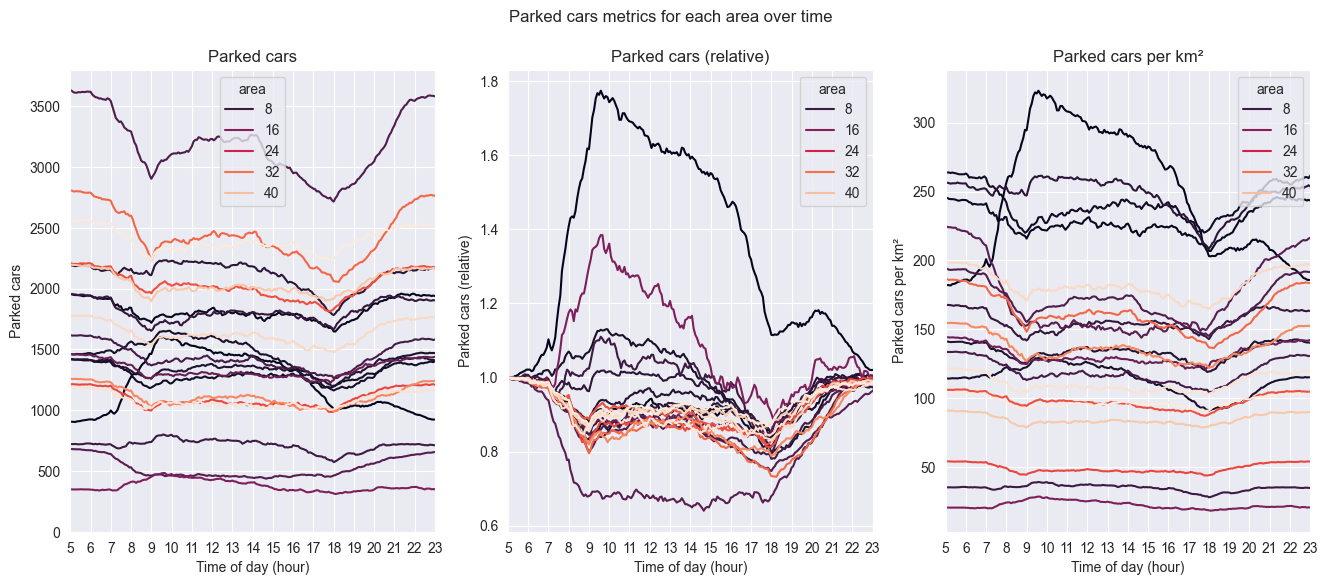

In [25]:
# Plot
fig, axs = plt.subplots(1, len(columns), figsize=(16, 6))
for i, col in enumerate(columns):
    sns.lineplot(data=parked_df_single, x='time', y=col, hue='area', ax=axs[i], palette='rocket')
    axs[i].set_title(f'{labels_park_dict[col]}')
    axs[i].set_ylabel(labels_park_dict[col])
    axs[i].set_xlabel('Time of day (hour)')
    axs[i].set_xlim(start_time, end_time)
    if col == 'value':
        axs[i].set_ylim(bottom=0)
    # Set x-tick labels
    axs[i].set_xticks(range(start_time, end_time+1))
# Set title
plt.suptitle('Parked cars metrics for each area over time')

# Save image
plt.savefig(f'../img/{image_folder}/parked_data_{image_name}.png', dpi=300, bbox_inches='tight')

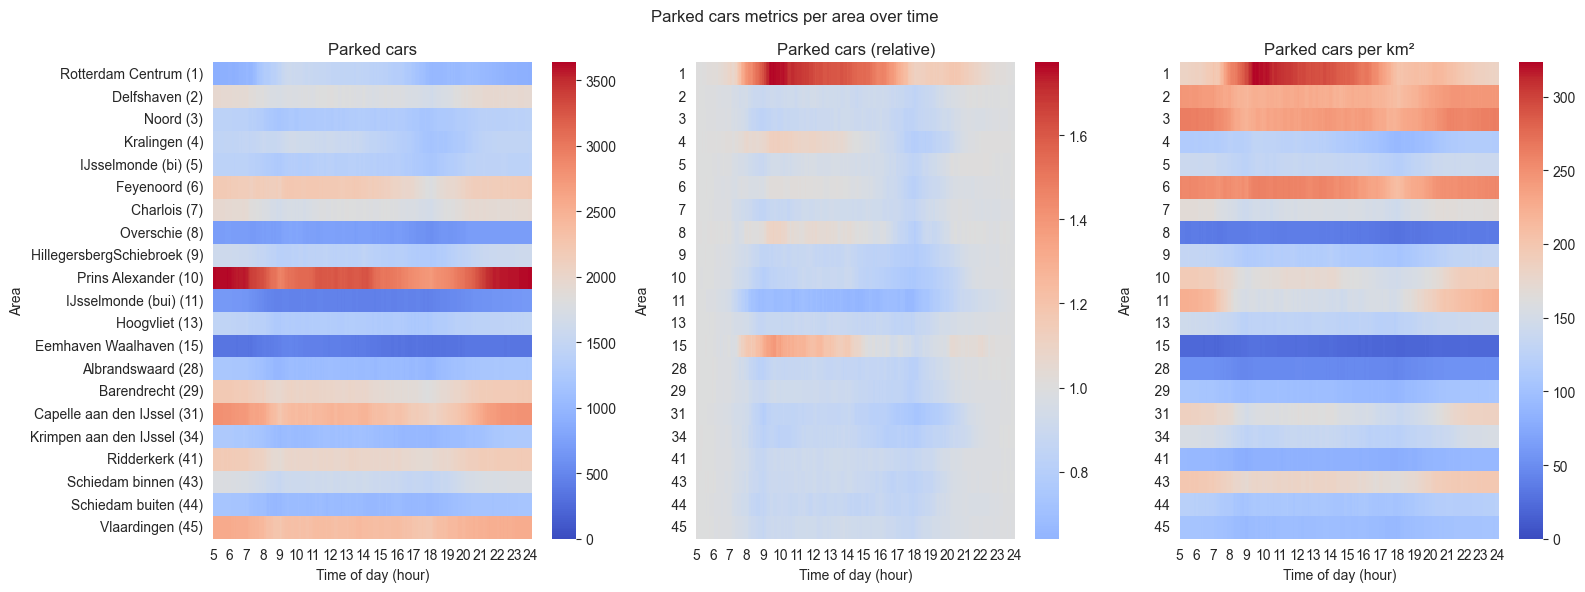

In [26]:
# Create a heatmaps of the parked cars data
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for i, col in enumerate(columns):
    unstacked = parked_df_single[col].unstack().T
    if i == 0:
        unstacked.index = [f"{area_names[area]} ({area})" for area in unstacked.index]
    else:
        unstacked.index = [f"    {area}" for area in unstacked.index]
    if col == 'parked_norm':
        sns.heatmap(unstacked, cmap='coolwarm', ax=axs[i], center=1)
    else:
        sns.heatmap(unstacked, cmap='coolwarm', ax=axs[i], vmin=0)
    axs[i].set_title(labels_park_dict[col])
    # Show fewer ticks by setting a step size
    time_range = range(start_time, end_time+2)  # Step size of 2 hours
    tick_positions = [(float(hour) - start_time)*12 for hour in time_range]
    axs[i].set_xticks(tick_positions)
    axs[i].set_xticklabels([f"{hour}" for hour in time_range], rotation=0)
    axs[i].set_ylabel('Area')
    axs[i].set_xlabel('Time of day (hour)')

plt.suptitle('Parked cars metrics per area over time')
plt.tight_layout()
plt.savefig(f'../img/{image_folder}/parked_heatmaps_{image_name}.png', dpi=300, bbox_inches='tight')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

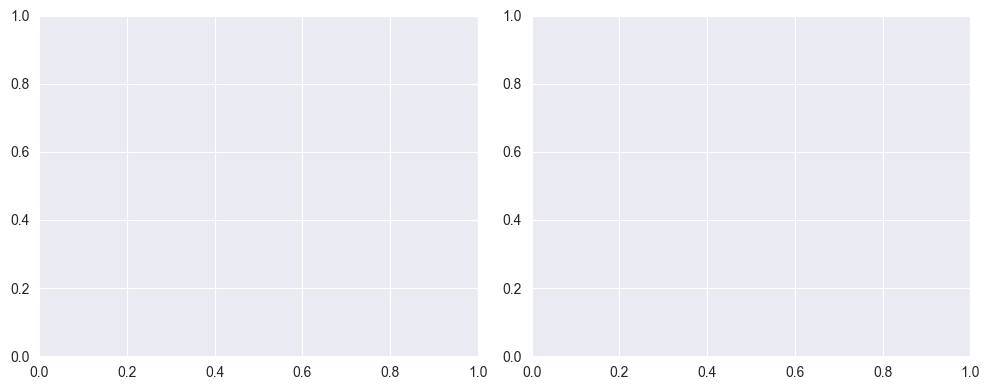

In [27]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import Normalize, TwoSlopeNorm
import numpy as np

def create_animated_choropleth_comparison(parked_df, gdf_mrdh_65, runs=runs, columns=['parked_norm', 'parked_density'], fps=2, step_time=1):
    # Get unique time steps
    time_steps = parked_df.index.get_level_values('time').unique()

    # Calculate the number of frames
    selected_times = np.arange(time_steps.min(), time_steps.max(), step_time)
    n_frames = len(selected_times)

    # Create a figure and axes
    fig, axs = plt.subplots(len(runs), len(columns), figsize=(len(columns) * 5, len(runs) * 4))
    fig.tight_layout()
    
    # Set up color scales for each metric
    norms = {}
    for column in columns:
        if column == 'parked_norm':
            vmin, vmax = parked_df[column].min(), parked_df[column].max()
            norms[column] = TwoSlopeNorm(vcenter=1.0, vmin=vmin, vmax=vmax)
        else:
            vmin, vmax = parked_df[column].min(), parked_df[column].max()
            norms[column] = Normalize(vmin=vmin, vmax=vmax)
    
    # Function to find the closest time step
    def find_closest_time(target_time):
        return time_steps[np.abs(time_steps - target_time).argmin()]
    
    # Create colorbars only once
    for j, column in enumerate(columns):
        cax = fig.add_axes([axs[-1, j].get_position().x0,
                            axs[-1, j].get_position().y0 - 0.05,
                            axs[-1, j].get_position().width,
                            0.02])
        plt.colorbar(plt.cm.ScalarMappable(norm=norms[column], cmap='coolwarm'),
                     cax=cax, orientation='horizontal', label=column)
    
    # Function to update the plot for each frame
    def update(frame):
        target_time = selected_times[frame]
        closest_time = find_closest_time(target_time)
        
        for i, run in enumerate(runs):
            for j, column in enumerate(columns):
                ax = axs[i, j]
                ax.clear()
                
                frame_data = parked_df.loc[run].xs(closest_time, level='time')
                
                # Merge with geodataframe
                merged = gdf_mrdh_65.merge(frame_data, left_index=True, right_index=True, how='left')
                
                # Plot the choropleth without legend
                merged.plot(column=column, ax=ax, cmap='coolwarm', 
                            norm=norms[column], legend=False)
                
                ax.set_title(f'{run.capitalize()} - {column}')
                ax.axis('off')
        
        fig.suptitle(f'Parked Cars Comparison\nTime: {closest_time:.2f} hours', fontsize=16)
        
        return axs.flatten()

    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=n_frames, interval=1000/fps, blit=False)
    
    # Save the animation as a video
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
    anim.save(f'../img/results/parked_cars_comparison_animation_{image_name}.mp4', writer=writer)
    
    plt.close(fig)

# Create the comparison animation
create_animated_choropleth_comparison(parked_df, gdf_mrdh_65)

print(f"Animation has been created and saved as 'parked_cars_comparison_animation_{image_name}.mp4' in the '../img/results/' directory.")